In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
data_raw = pd.read_csv('data/data.csv')
features_raw = pd.read_csv('data/features.csv')
data = data_raw.copy(deep = True).dropna()
features = features_raw.copy(deep = True)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      3988 non-null   object
 1   Headline  3988 non-null   object
 2   Body      3988 non-null   object
 3   Label     3988 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 155.8+ KB


In [87]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   number_of_future_verbs                3988 non-null   float64
 1   number_of_premise_conclusion_markers  3988 non-null   float64
 2   number_of_sentences                   3988 non-null   float64
 3   average_sentence_lenght               3988 non-null   float64
 4   number_of_words                       3988 non-null   float64
 5   average_word_lenght                   3988 non-null   float64
 6   dictionary_percentage                 3988 non-null   float64
dtypes: float64(7)
memory usage: 219.4 KB


### Sentiment Feature Extraction 

#TODO: Try dl

In [9]:
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# nltk.download('vader_lexicon')
# nltk.download('punkt')

def nltk_sentiment(text):
    score_compound = []
    sid = SentimentIntensityAnalyzer()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    try:
        sentences = tokenizer.tokenize(text)
    except:
        print(text)
    for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            score_compound.append(scores['compound'])

    return np.mean(score_compound)


In [10]:
from textblob import TextBlob

def subjectivity_score(text):
    return TextBlob(text).sentiment[1]

In [11]:
def num_sentences(text):
    try:
        return len(text.split('.'))
    except:
        print(text)
def avg_num_words(text):
    num_sentence = num_sentences(text)
    return round(len(text.split())/num_sentence, 2)

In [12]:
from transformers import BertTokenizer
from sentiment_bert import SentimentBERT
import torch

model = SentimentBERT(3)
model.load_state_dict(torch.load('models/state_dict_sentbert.pt', map_location=torch.device('cpu')))
# model.eval()

def bert_sentiment(text):
  pos_cnt, neu_cnt, neg_cnt = 0, 0, 0
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

  for sent in text.split('.'):
    encoded_review = tokenizer.encode_plus(
      sent,
      max_length=128,
      add_special_tokens=True,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    if int(prediction) == 0:
      neg_cnt += 1
    if int(prediction) == 1:
      neu_cnt += 1
    if int(prediction) == 2:
      pos_cnt += 1
  
  return (pos_cnt - neg_cnt)/(pos_cnt + neu_cnt + neg_cnt)

FileNotFoundError: [Errno 2] No such file or directory: 'models/state_dict_sentbert.pt'

In [14]:
data['nltk_sentiment'] = data.Body.apply(nltk_sentiment)
# data['bert_sentment'] = data.Body.apply(bert_sentiment)
data['subjectivity'] = data.Body.apply(subjectivity_score)
data['num_sent'] = data.Body.apply(num_sentences)
data['avg_num_words'] = data.Body.apply(avg_num_words)

In [108]:
data[data.isna().any(axis=1)]

,URLs,Headline,Body,Label,subjectivity,sentiment,num_sent,avg_num_words


In [107]:
#TODO NAN in features

features[features.isna().any(axis=1)]

,number_of_future_verbs,number_of_premise_conclusion_markers,number_of_sentences,average_sentence_lenght,number_of_words,average_word_lenght,dictionary_percentage
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
973,NaN,NaN,NaN,NaN,NaN,NaN,NaN
981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
new_features = ['number_of_future_verbs', 'number_of_premise_conclusion_markers', 'dictionary_percentage']
data = pd.concat([data, features[new_features]], axis = 1).dropna()

In [110]:
data.to_csv('data/data_features.csv', index=False)

In [8]:
data = pd.read_csv('data/data_features.csv')

In [112]:
features = ['nltk_sentiment', 'subjectivity', 'num_sent', 'avg_num_words', 'number_of_premise_conclusion_markers', 'dictionary_percentage']
labels = ['Label']
X = data[features]
y = data[labels]

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [115]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.554395
         Iterations 7
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.199      
Dependent Variable:        Label                  AIC:                    3106.6318  
Date:                      2020-12-16 12:35       BIC:                    3142.2367  
No. Observations:          2791                   Log-Likelihood:         -1547.3    
Df Model:                  5                      LL-Null:                -1932.0    
Df Residuals:              2785                   LLR p-value:            5.1420e-164
Converged:                 1.0000                 Scale:                  1.0000     
No. Iterations:            7.0000                                                    
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z     P>|z|   [0.

In [117]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [118]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.63      0.72       664
         1.0       0.65      0.85      0.74       533

    accuracy                           0.73      1197
   macro avg       0.75      0.74      0.73      1197
weighted avg       0.76      0.73      0.73      1197



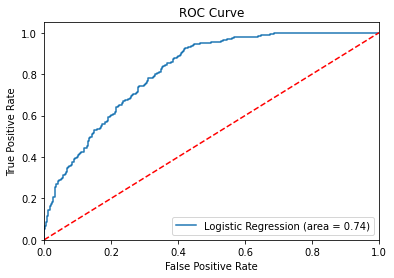

In [125]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [6]:
data = pd.read_csv('data/data_bertsent.csv')
features = pd.read_csv('data/features.csv')
new_features = ['number_of_future_verbs', 'number_of_premise_conclusion_markers', 'dictionary_percentage']

data = pd.concat([data, features[new_features]], axis = 1).dropna()

In [15]:
data.describe()

,Unnamed: 0,Label,bert_sentiment,number_of_future_verbs,number_of_premise_conclusion_markers,dictionary_percentage,nltk_sentiment,subjectivity,num_sent,avg_num_words
count,3968.000000,3968.000000,3968.000000,3968.0,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000
mean,2007.898185,0.469506,0.018607,0.0,2.294355,0.712615,0.015388,0.430639,27.976562,18.088710
std,1157.273125,0.499132,0.515592,0.0,1.097720,0.226290,0.257221,0.170463,30.320009,6.014776
min,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,-0.951600,0.000000,1.000000,2.170000
25%,1008.750000,0.000000,-0.384615,0.0,2.000000,0.681818,-0.087791,0.358088,7.000000,14.067500
50%,2009.500000,0.000000,0.000000,0.0,2.000000,0.812278,0.034100,0.425000,20.000000,17.545000
75%,3009.250000,1.000000,0.333333,0.0,3.000000,0.854090,0.172117,0.499993,41.000000,22.082500
max,4008.000000,1.000000,1.000000,0.0,7.000000,1.000000,0.915300,1.000000,436.000000,49.000000


In [28]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# create dataset
features = ['nltk_sentiment', 'bert_sentiment', 'subjectivity', 'num_sent', 'avg_num_words', 'number_of_premise_conclusion_markers', 'dictionary_percentage']
labels = ['Label']
X = data[features]
y = data[labels]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.707 (0.020)


In [29]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.558836
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.192      
Dependent Variable: Label            AIC:              3561.4923  
Date:               2020-12-17 23:47 BIC:              3603.9315  
No. Observations:   3174             Log-Likelihood:   -1773.7    
Df Model:           6                LL-Null:          -2195.9    
Df Residuals:       3167             LLR p-value:      4.0476e-179
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
---------------------------------------------------------------------
       Coef.     Std.Err.       z        P>|z|      [0.025     0.975]
---------------------------------------------------------------------
x1     0.2723      0.0514      5.3009    0.0000     0.1716     0.3730
x2    -0.9599      0.0511    -18.7699    

In [25]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', verbose = True, decision_function_shape = 'ovo') 
clf = make_pipeline(StandardScaler(), clf)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

[LibSVM]

/Users/tianzong/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
from sklearn import metrics


# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.739294710327456
Precision: 0.7121212121212122
Recall: 0.752
